In [1]:
import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from metrics import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm

In [2]:
import os
os.chdir("../Figure2")

# DeepCOI

In [3]:
labels = np.load("../data/meta/phylum.meta.npz", allow_pickle=True)
dag = labels['DAG'][()].toarray()
labels = labels['names']

In [4]:
def load_predictions(phylum, prefix='DeepCOI-phylum'):
    def get_trues(phylum, n):
        idx = np.where(labels == phylum)[0][0]
        label = dag[:, idx]
        
        return np.stack([label for i in range(n)])
        
    preds = np.load(f"DeepCOI/{prefix}.{phylum}.npy", allow_pickle=True)[()]
    preds = np.array(list(preds.values()))
    
    trues = get_trues(phylum, preds.shape[0])
    
    return trues, preds

In [8]:
def get_curves(y_true, y_pred):
    # ROC curve
    fpr, tpr, auroc, (th, th_fpr) = prepare(y_true, y_pred, labels, metric='roc', return_th=True)

    # PR curve
    precision, recall, aupr = prepare(y_true, y_pred, labels, metric='pr')

    return {
        "FPR": fpr, "TPR": tpr, "AUROC": auroc,
        "Precision": precision, "Recall": recall, "AUPR": aupr,
        "thresholds": th, "th_fpr": th_fpr
    }

In [5]:
phyla = [
    'Annelida',
    'Arthropoda',
    'Chordata',
    'Cnidaria',
    'Echinodermata',
    'Mollusca',
    'Nematoda',
    'Platyhelminthes',
    'outgroups',
]

In [6]:
tmp_trues, tmp_preds = [], []
for phylum in phyla:
    trues, preds = load_predictions(phylum, "DeepCOI-phylum")
    tmp_trues.append(trues)
    tmp_preds.append(preds)
    
y_true = np.concatenate(tmp_trues)
y_pred = np.concatenate(tmp_preds)

In [9]:
coi_curves = get_curves(y_true, y_pred)

# RDP

In [10]:
def load_rdp(phylum):
    def get_vector(pred, prob):
        n = len(phyla)
        idx = np.where(labels == pred)[0][0]
        
        x = np.arange(n, dtype=np.double)
        probs = np.full_like(x, (1-prob)/(n-1), dtype=np.double)
        probs[idx] = prob
        
        return probs
    
    def get_trues(phylum, n):
        idx = np.where(labels == phylum)[0][0]
        label = dag[:, idx]
        
        return np.stack([label for i in range(n)])
        
    probs = []
    f = open(f"RDP/{phylum}.rdp.test.txt", 'r')
    for line in f:
        items = line.strip().split('\t')
        pred = items[-3]
        prob = float(items[-1])
        
        probs.append(get_vector(pred, prob))
    f.close()
    
    y_pred = np.stack(probs)
    y_true = get_trues(phylum, y_pred.shape[0])
    
    return y_true, y_pred

In [11]:
tmp_trues, tmp_preds = [], []
for phylum in phyla:
    trues, preds = load_rdp(phylum)
    tmp_trues.append(trues)
    tmp_preds.append(preds)
    
rdp_true = np.concatenate(tmp_trues)
rdp_pred = np.concatenate(tmp_preds)

In [12]:
rdp_curves = get_curves(rdp_true, rdp_pred)

# Figure

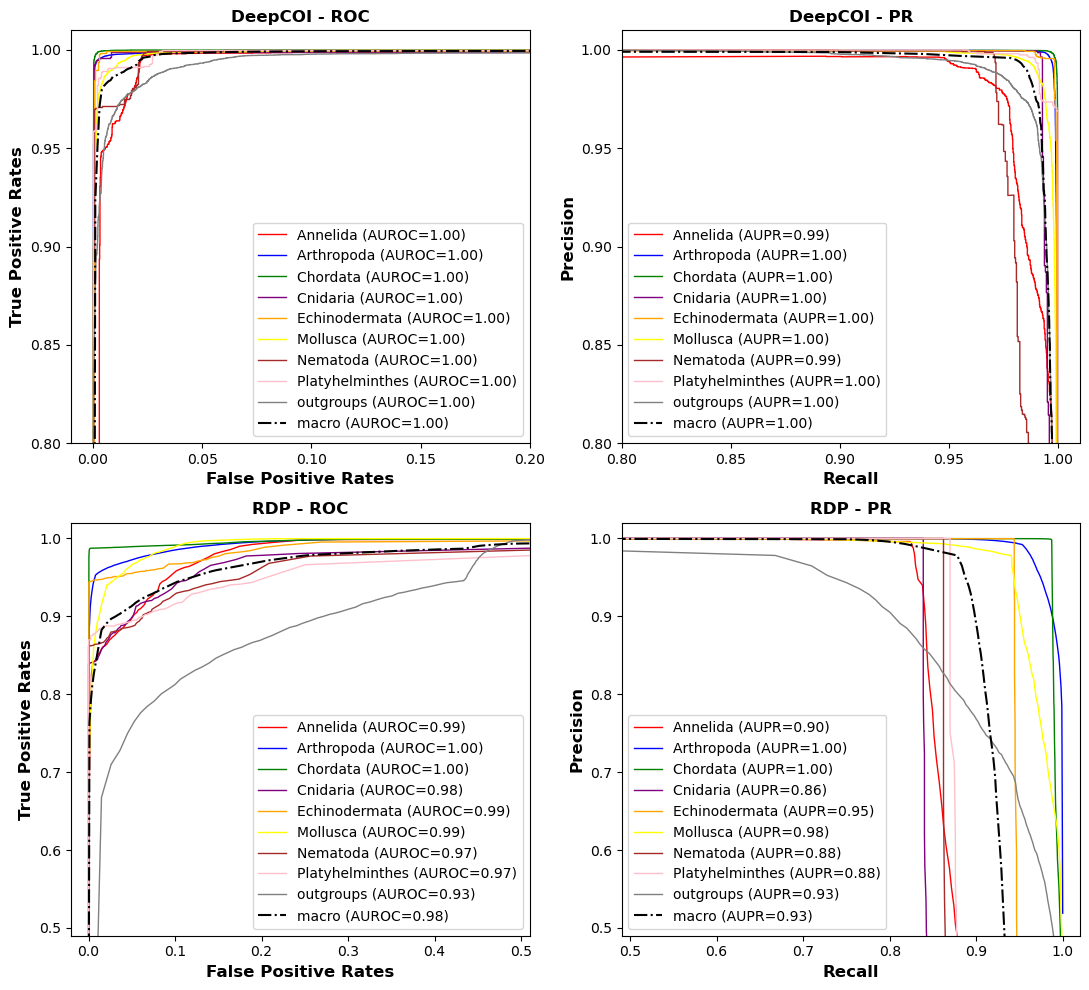

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(11, 10))

colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'grey']
legend_fontsize = 10
label_fontsize = 12

for i, phylum in enumerate(phyla):
    ax[0,0].plot(
        coi_curves['FPR'][phylum], 
        coi_curves['TPR'][phylum],
        label=f"{phylum} (AUROC={coi_curves['AUROC'][phylum]:.2f})",
        color=colors[i],
        linewidth=1,
    )
    
ax[0,0].plot(
    coi_curves['FPR']['macro'],
    coi_curves['TPR']['macro'],
    label=f"macro (AUROC={coi_curves['AUROC']['macro']:.2f})",
    color='black',
    linestyle='-.',
)
    
ax[0,0].set_xlabel("False Positive Rates", fontweight='bold', fontsize=label_fontsize)
ax[0,0].set_ylabel("True Positive Rates", fontweight='bold', fontsize=label_fontsize)
ax[0,0].set_title("DeepCOI - ROC", fontweight='bold', fontsize=label_fontsize)
_ = ax[0,0].set(
    xlim=(-0.01, 0.2),
    ylim=(0.8, 1.01),
)
ax[0,0].legend(fontsize=legend_fontsize)
ax[0,0].locator_params(axis='both', nbins=5)

for i, phylum in enumerate(phyla):
    ax[0,1].plot(
        coi_curves['Recall'][phylum], 
        coi_curves['Precision'][phylum],
        label=f"{phylum} (AUPR={coi_curves['AUPR'][phylum]:.2f})",
        color=colors[i],
        linewidth=1,
    )
    
ax[0,1].plot(
    coi_curves['Recall']['macro'],
    coi_curves['Precision']['macro'],
    label=f"macro (AUPR={coi_curves['AUPR']['macro']:.2f})",
    color='black',
    linestyle='-.',
)
    
ax[0,1].set_xlabel("Recall", fontweight='bold', fontsize=label_fontsize)
ax[0,1].set_ylabel("Precision", fontweight='bold', fontsize=label_fontsize)
ax[0,1].set_title("DeepCOI - PR", fontweight='bold', fontsize=label_fontsize)
_ = ax[0,1].set(
    xlim=(0.8, 1.01),
    ylim=(0.8, 1.01),
)
ax[0,1].legend(fontsize=legend_fontsize)
ax[0,1].locator_params(axis='both', nbins=5)

for i, phylum in enumerate(phyla):
    ax[1,0].plot(
        rdp_curves['FPR'][phylum], 
        rdp_curves['TPR'][phylum],
        label=f"{phylum} (AUROC={rdp_curves['AUROC'][phylum]:.2f})",
        color=colors[i],
        linewidth=1,
    )
    
ax[1,0].plot(
    rdp_curves['FPR']['macro'],
    rdp_curves['TPR']['macro'],
    label=f"macro (AUROC={rdp_curves['AUROC']['macro']:.2f})",
    color='black',
    linestyle='-.',
)
    
ax[1,0].set_xlabel("False Positive Rates", fontweight='bold', fontsize=label_fontsize)
ax[1,0].set_ylabel("True Positive Rates", fontweight='bold', fontsize=label_fontsize)
ax[1,0].set_title("RDP - ROC", fontweight='bold', fontsize=label_fontsize)
_ = ax[1,0].set(
    xlim=(-0.02, 0.51),
    ylim=(0.49, 1.02),
)
ax[1,0].legend(fontsize=legend_fontsize)
#ax[0].locator_params(axis='both', nbins=5)

for i, phylum in enumerate(phyla):
    ax[1,1].plot(
        rdp_curves['Recall'][phylum], 
        rdp_curves['Precision'][phylum],
        label=f"{phylum} (AUPR={rdp_curves['AUPR'][phylum]:.2f})",
        color=colors[i],
        linewidth=1,
    )
    
ax[1,1].plot(
    rdp_curves['Recall']['macro'],
    rdp_curves['Precision']['macro'],
    label=f"macro (AUPR={rdp_curves['AUPR']['macro']:.2f})",
    color='black',
    linestyle='-.',
)
    
ax[1,1].set_xlabel("Recall", fontweight='bold', fontsize=label_fontsize)
ax[1,1].set_ylabel("Precision", fontweight='bold', fontsize=label_fontsize)
ax[1,1].set_title("RDP - PR", fontweight='bold', fontsize=label_fontsize)
_ = ax[1,1].set(
    xlim=(0.49, 1.02),
    ylim=(0.49, 1.02),
)
ax[1,1].legend(fontsize=legend_fontsize)
#ax[1].locator_params(axis='both', nbins=5)

plt.tight_layout()

In [14]:
fig.savefig("../Figures/Figure2.pdf", format='pdf', bbox_inches='tight')